# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [166]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [167]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [168]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [169]:
# Setup paths
POS_PATH = os.path.join('data', 'positive2')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor2')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [170]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [104]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [171]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

## 3.2 Preprocessing - Scale and Resize

In [106]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [107]:
img = preprocess('application_data\\input_image\\input_image.jpg')

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_image.jpg : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]

In [108]:
img.numpy().max() 

NameError: name 'img' is not defined

In [109]:
plt.imshow(img)

NameError: name 'img' is not defined

In [ ]:
dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [110]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [111]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [112]:
samples = data.as_numpy_iterator()

In [113]:
exampple = samples.next()

In [114]:
exampple

(b'data\\anchor2\\edebbc22-4fda-11ed-a131-f8ac65b21ebc.jpg',
 b'data\\positive2\\b1f2fe40-4fdb-11ed-83fc-f8ac65b21ebc.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [115]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [116]:
res = preprocess_twin(*exampple)

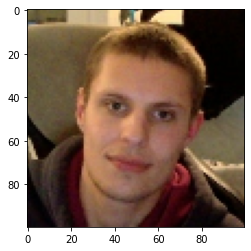

In [117]:
plt.imshow(res[1])

In [118]:
res[2]

1.0

In [119]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [120]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [121]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [122]:
inp = Input(shape=(100,100,3), name='input_image')

In [123]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_8')>

In [124]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [125]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [126]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [127]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [128]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [129]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [130]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [131]:
embedding = make_embedding()

In [132]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [133]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [134]:
l1 = L1Dist()

In [135]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

## 4.3 Make Siamese Model

In [136]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [137]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [138]:
siamese_layer = L1Dist()

In [139]:
distances = siamese_layer(inp_embedding, val_embedding)

In [140]:
classifier = Dense(1, activation='sigmoid')(distances)

In [141]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [142]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [143]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [144]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [145]:
siamese_model = make_siamese_model()

In [146]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [147]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [148]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [149]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [150]:
test_batch = train_data.as_numpy_iterator()

In [151]:
batch_1 = test_batch.next()

In [152]:
X = batch_1[:2]

In [153]:
y = batch_1[2]

In [154]:
y

array([0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.],
      dtype=float32)

In [155]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
      floating-point value which either represents a
      [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
      when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
      `from_logits=False`).

    **Recommended Usage:** (set `from_logits=True`)

    With `tf.keras` API:

    ```python
    model.compile(
      loss=tf.keras.losses

In [156]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [157]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [ ]:
EPOCHS = 50 # num times we will run through the training data
train(train_data, EPOCHS)

# 6. Evaluate Model

In [158]:
siamese_model = tf.keras.models.load_model('siamesemodel_2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

## 6.1 Import Metrics

In [159]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [165]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [160]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [161]:
# unpacks batch
test_input, test_validation, y_true = test_data.as_numpy_iterator().next()

In [162]:
test_validation

array([[[[4.62009817e-01, 4.33333337e-01, 3.01715672e-01],
         [4.74754900e-01, 4.48039204e-01, 3.26225489e-01],
         [4.70098048e-01, 4.44117635e-01, 3.29656869e-01],
         ...,
         [6.69117644e-02, 2.52450984e-02, 8.82352982e-03],
         [5.29411770e-02, 2.35294122e-02, 9.80392215e-04],
         [5.49019612e-02, 2.74509806e-02, 3.92156886e-03]],

        [[4.61764693e-01, 4.44117635e-01, 3.01960796e-01],
         [4.54656869e-01, 4.36029404e-01, 3.04656863e-01],
         [4.59803909e-01, 4.46078420e-01, 3.19607854e-01],
         ...,
         [5.31862751e-02, 1.69117656e-02, 1.71568629e-03],
         [4.82843146e-02, 1.76470596e-02, 5.14705898e-03],
         [4.50980403e-02, 2.54901964e-02, 9.80392192e-03]],

        [[4.49264705e-01, 4.28676456e-01, 2.81617641e-01],
         [4.49999988e-01, 4.27941173e-01, 2.89950967e-01],
         [4.38235283e-01, 4.21323538e-01, 2.88480401e-01],
         ...,
         [4.41176482e-02, 2.15686280e-02, 9.80392192e-03],
         [

In [175]:
# makes prediction
y_pred = siamese_model.predict([test_input, test_validation])
y_pred

1/1 [==============================] - 1s 880ms/step


array([[1.0000000e+00],
       [9.9932790e-01],
       [6.5996223e-06],
       [5.1864947e-05],
       [1.0000000e+00],
       [9.9999976e-01],
       [5.7339834e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999738e-01],
       [9.9999982e-01],
       [9.9781206e-10],
       [1.0000000e+00],
       [9.9999315e-01],
       [9.3020319e-10]], dtype=float32)

In [ ]:
# if prediction is > 0.5, we want our result to add a 1
results = []
for prediction in y_pred:
    if prediction > 0.5:
        results.append(1)
    else:
        results.append(0)
results

In [ ]:
y_true

## 6.3 Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

## 6.4 Viz Results

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_validation[1])

# Renders cleanly
plt.show()

# 7. Save Model

In [ ]:
# Save model (with its weights)
#siamese_model.save('siamese_model.h5')

In [ ]:
L1Dist

In [ ]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel_2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
y_pred = model.predict([test_input, test_val])
[1 if prediction > 0.5 else 0 for prediction in y_pred ]


In [ ]:
y_true

In [ ]:
# View model summary
model.summary()

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [92]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        prediction = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        print(prediction)
        result2= [1 if prediction > 0.05 else 0 for prediction in prediction ]
        
        print(result2)
        results.append(prediction)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [93]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 274ms/step
[[0.9991386]]
[0]
1/1 [==============================] - 0s 223ms/step
[[0.9991386]]
[0]
1/1 [==============================] - 0s 276ms/step
[[0.9991386]]
[0]
1/1 [==============================] - 0s 227ms/step
[[0.9991386]]
[0]
1/1 [==============================] - 0s 244ms/step
[[0.98347276]]
[0]
1/1 [==============================] - 0s 261ms/step
[[0.98347276]]
[0]
1/1 [==============================] - 0s 238ms/step
[[0.98347276]]
[0]
1/1 [==============================] - 0s 234ms/step
[[0.98347276]]
[0]
1/1 [==============================] - 0s 210ms/step
[[0.99623126]]
[0]
1/1 [==============================] - 0s 252ms/step
[[0.99623126]]
[0]
1/1 [==============================] - 0s 250ms/step
[[0.99623126]]
[0]
1/1 [==============================] - 0s 181ms/step
[[0.99623126]]
[0]
1/1 [==============================] - 0s 194ms/step
[[0.9949164]]
[0]
1/1 [==============================] - 0s 234ms/step
[[0.9949164]]
[0

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
32/50

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(3, 250)
cap.set(4, 250)

while True:
    ret, frame = cap.read()

    if cv2.waitKey(1) & 0xFF == ord("c"):
        imname = os.path.join("application_data", "input_image", "input_img.jpg")
        cv2.imwrite(imname, frame)

        results, verified = verify(model, 0.7, 0.4)
        print(verified)

    cv2.imshow("verification", frame) # shows image 
    if cv2.waitKey(20) & 0xFF == 27: # allows keyboard press to close window with the escape key
        break

cap.release() 
cv2.destroyAllWindows()

In [ ]:
for image in os.listdir(os.path.join("application_data", "input_image")):
    preprocess(os.path.join('application_data', 'input_image', image))
    #preprocess(os.path.join('application_data', 'verification_images', image))

for image in os.listdir(os.path.join('application_data', 'verification_images')):
    preprocess(os.path.join('application_data', 'verification_images', image))

In [ ]:
input_path = os.path.join("application_data", "input_image")
validation_path = os.path.join("application_data", "verification_images")
input_img = tf.data.Dataset.list_files(input_path+"/*.jpg").take(16)
validation_img = tf.data.Dataset.list_files(validation_path+"/*.jpg").take(16)

application_images = tf.data.Dataset.zip((input_img, validation_img, tf.data.Dataset.from_tensor_slices(tf.ones(2))))
#plication_images2 = tf.data.Dataset.zip((input_img, validation_img, tf.data.Dataset.from_tensor_slices(tf.ones(2))))
#application_images = application_images.concatenate(application_images2)

application_images = application_images.map(preprocess_twin)
application_images = application_images.cache()


application_inp = application_images.take(16)
application_inp = application_inp.batch(16)
application_inp = application_inp.prefetch(8)

test_inp, test_validation2, y_false = application_inp.as_numpy_iterator().next()

In [ ]:
model.predict([test_inp, test_validation2])

In [ ]:
application_inp.as_numpy_iterator().next()

In [ ]:
test_input 

In [ ]:
test_inp

In [ ]:
input_img.shape

In [ ]:
result = model.predict([test_inp, test_validation2])
result2= [1 if prediction > 0.5 else 0 for prediction in result ]
print(result2)
result2.append(result)


In [ ]:
results,verified = verify(model, 0.5, 0.5)
print(verified)
